In [1]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']
News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las

In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

# Convert and verify date columns
news_embeddings['news_date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['speech_date'] = pd.to_datetime(speeches_embeddings['date'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Temporal window calculation and expansion
def generate_temporal_pairs(news_df, speeches_df, window_days=3):
    """Generate news-speech pairs within a symmetric temporal window (-4 to +4 days)"""
    pairs = []
    chunk_size = 2000
    news_chunks = np.array_split(news_df, len(news_df) // chunk_size + 1)
    
    for chunk in news_chunks:
        for _, row in chunk.iterrows():
            news_date = row['news_date']
            start_date = news_date - pd.Timedelta(days=window_days) 
            end_date = news_date + pd.Timedelta(days=window_days)  
            
            mask = (speeches_df['speech_date'] >= start_date) & (speeches_df['speech_date'] <= end_date)
            speech_ids = speeches_df[mask].index.tolist()
            pairs.extend([(row.name, s_id) for s_id in speech_ids])
    
    return pd.DataFrame(pairs, columns=['news_id', 'speech_id'])


alignment_df = generate_temporal_pairs(news_embeddings, speeches_embeddings)

#optimized embeddings calculation
def load_embeddings_half(df, col_name):
    embeddings = []
    for i, row in df.iterrows():
        if isinstance(row[col_name], str):
            arr = np.fromstring(row[col_name].strip("[]"), sep=" ", dtype=np.float16)
        else:
            arr = np.array(row[col_name], dtype=np.float16)
        embeddings.append(torch.tensor(arr, device=device).half())
        if i % 1000 == 0: torch.cuda.empty_cache()
    return torch.stack(embeddings)

news_tensor = load_embeddings_half(news_embeddings, 'news_embeddings')
speeches_tensor = load_embeddings_half(speeches_embeddings, 'speech_embeddings')

#Batched cosine similarity computation
def compute_cosine_similarities(pairs_df, news_emb, speech_emb, batch_size=8192):
    news_norm = F.normalize(news_emb, p=2, dim=1)
    speech_norm = F.normalize(speech_emb, p=2, dim=1)
    similarities = []
    for i in range(0, len(pairs_df), batch_size):
        batch = pairs_df.iloc[i:i+batch_size]
        news_batch = news_norm[batch['news_id'].values]
        speech_batch = speech_norm[batch['speech_id'].values]
        similarities.append(F.cosine_similarity(news_batch, speech_batch).cpu().numpy())
        del news_batch, speech_batch
        torch.cuda.empty_cache()
    return np.concatenate(similarities)

alignment_df['cosine_similarity'] = compute_cosine_similarities(alignment_df, news_tensor, speeches_tensor)

#include metadata to the embeddings to track temporal dependencies
def add_temporal_features(pairs_df, news_df, speeches_df):
    pairs_df = pairs_df.merge(
        news_df[['news_date']],
        left_on='news_id',
        right_index=True
    ).merge(
        speeches_df[['speech_date']],
        left_on='speech_id',
        right_index=True
    )
    pairs_df['days_diff'] = (pairs_df['news_date'] - pairs_df['speech_date']).dt.days
    return pairs_df

enriched_df = add_temporal_features(alignment_df, news_embeddings, speeches_embeddings)

#Save data to avoid rerunning everything again 
enriched_df.to_parquet('news_speech_similarities.parquet', engine='pyarrow', compression='zstd')
print("Processing complete. Results saved with columns:", enriched_df.columns.tolist())

Using device: cuda


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing complete. Results saved with columns: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff']


Data types:
 news_id                       int64
speech_id                     int64
cosine_similarity           float32
news_date            datetime64[ns]
speech_date          datetime64[ns]
days_diff                     int64
dtype: object


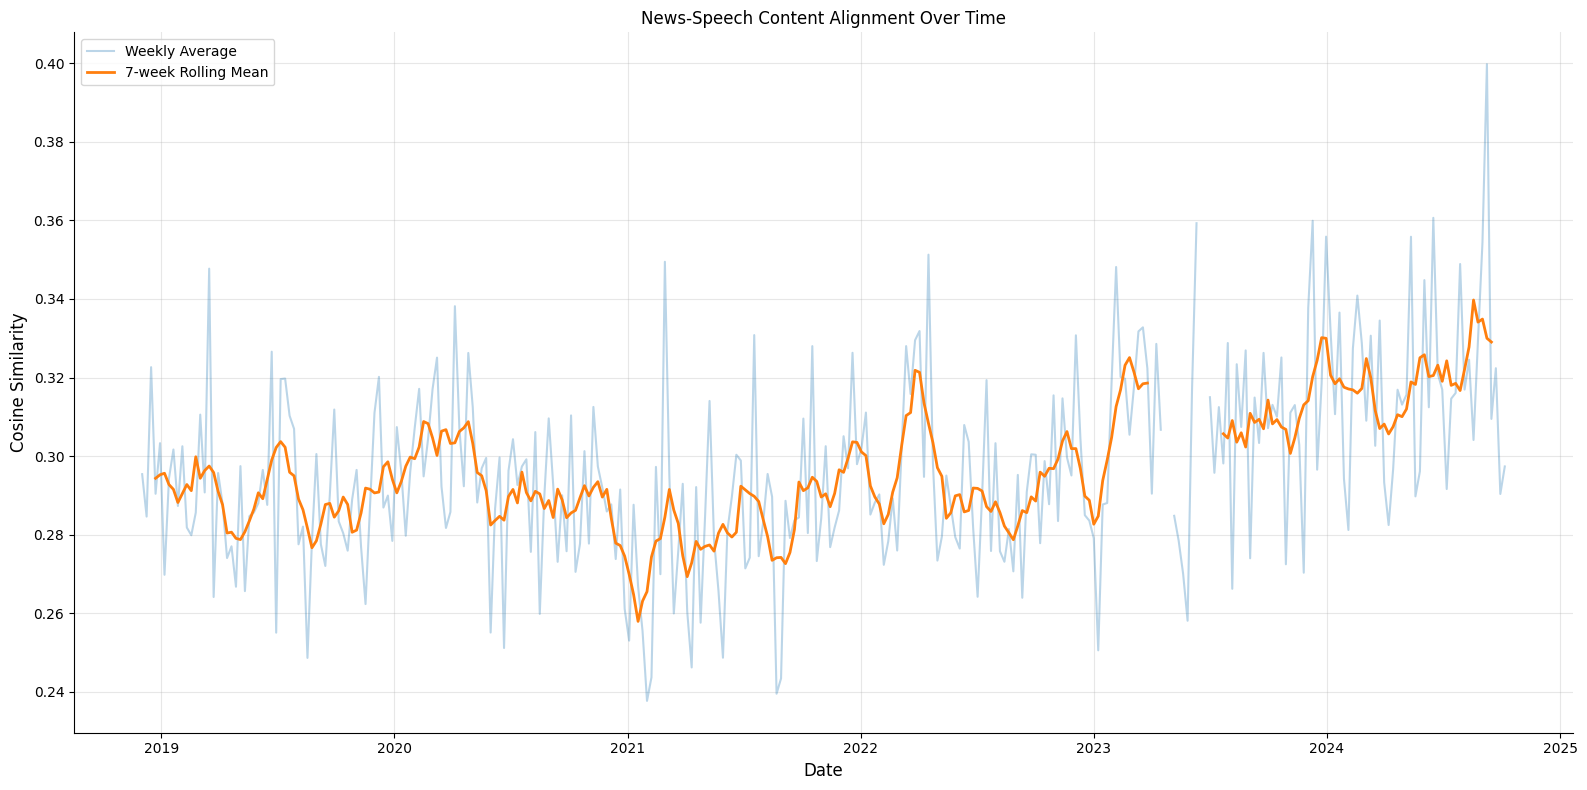

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


def load_safe_data():
    """Load data with proper dtype conversions"""
    df = pd.read_parquet('news_speech_similarities.parquet').astype({
        'news_id': 'int64',
        'speech_id': 'int64',
        'cosine_similarity': 'float32'  # Convert from float16 to float32
    })
    df['news_date'] = pd.to_datetime(df['news_date'])
    return df

# Load processed data
df = load_safe_data()

#Code to include temporal features
def plot_temporal_trends(df, resample_freq='W', rolling_window=7):
    """Plot similarity trends with type-safe processing"""
    plt.figure(figsize=(16, 8))
    
    # Ensure float32 type
    temp_df = df[['news_date', 'cosine_similarity']].copy()
    temp_df['cosine_similarity'] = temp_df['cosine_similarity'].astype('float32')
    
    # Resample data
    df_temp = temp_df.set_index('news_date')
    resampled = df_temp['cosine_similarity'].resample(resample_freq).mean()
    
    # Create rolling average
    rolling_mean = resampled.rolling(window=rolling_window, center=True).mean()
    
    # Plot with enhanced formatting
    plt.plot(resampled.index, resampled.values, 
            alpha=0.3, label='Weekly Average')
    plt.plot(rolling_mean.index, rolling_mean.values,
            linewidth=2, label=f'{rolling_window}-week Rolling Mean')
    
    plt.title('News-Speech Content Alignment Over Time')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cosine Similarity', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

#Testing execution code, tho not for testing 
if __name__ == "__main__":
    df = load_safe_data()
    
    # Verify data types
    print("Data types:\n", df.dtypes)
    
    # Plot temporal trends only
    plot_temporal_trends(df)

<ipython-input-4-ba7d437ad4eb>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()


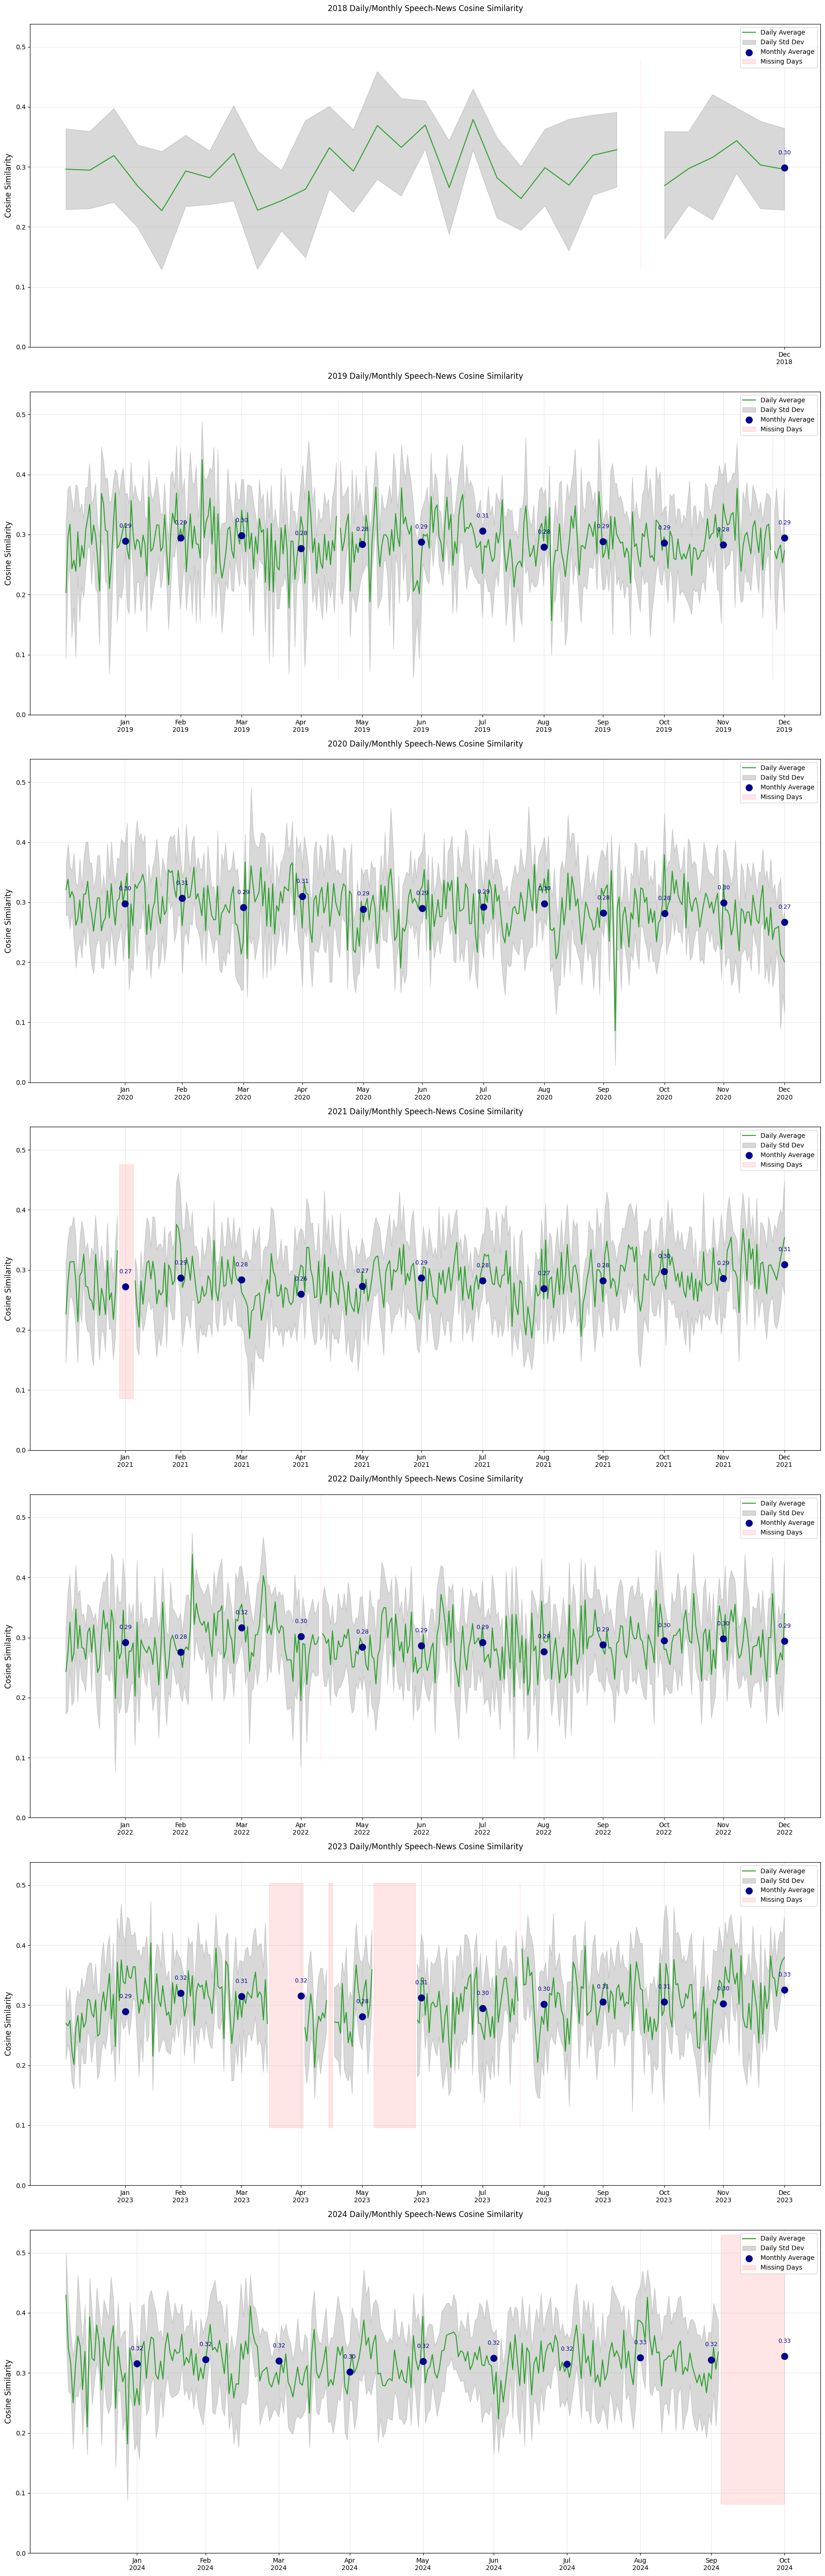

In [4]:
# Load processed data
df = pd.read_parquet('news_speech_similarities.parquet') #We can use this code when we compute everything again, else we have to roead the parquet
#df = pd.read_parquet(SIMILARITIES_PATH) #Piece of code when we have the path defined, otherwise it'll work by loading them again. 
# Convert to datetime and normalize (remove time components)
df['news_date'] = pd.to_datetime(df['news_date']).dt.normalize()
df['year'] = df['news_date'].dt.year

# Create daily aggregates with std dev
daily_agg = df.groupby('news_date')['cosine_similarity'].agg(['mean', 'std']).reset_index()
daily_agg.columns = ['date', 'cosine_similarity', 'std_dev']

# Extend full_dates to include October 2024 explicitly
end_date = pd.to_datetime('2024-10-31')  # Adjust as needed
full_dates = pd.date_range(
    start=daily_agg['date'].min(), 
    end=end_date, 
    freq='D'
)
daily_agg = daily_agg.set_index('date').reindex(full_dates).reset_index().rename(columns={'index': 'date'})

# Calculate bounds
daily_agg['upper_bound'] = daily_agg['cosine_similarity'] + daily_agg['std_dev'].fillna(0)
daily_agg['lower_bound'] = daily_agg['cosine_similarity'] - daily_agg['std_dev'].fillna(0)

# Create monthly aggregates (fill NaN with 0 for plotting)
monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()
monthly_agg['month_label'] = monthly_agg['date'].dt.strftime('%b\n%Y')

# Get unique years present in data
years = daily_agg['date'].dt.year.unique()

# Set up plot
plt.figure(figsize=(18, 8 * len(years)))

for i, year in enumerate(years, 1):
    year_mask = daily_agg['date'].dt.year == year
    yearly_daily = daily_agg[year_mask]
    yearly_monthly = monthly_agg[monthly_agg['date'].dt.year == year]
    
    if yearly_daily.empty:
        continue
    
    ax = plt.subplot(len(years), 1, i)
    
    # Daily plot with variability
    ax.plot(yearly_daily['date'], 
            yearly_daily['cosine_similarity'], 
            color='#2ca02c', 
            linewidth=1.5,
            label='Daily Average')
    
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['upper_bound'],
                    yearly_daily['lower_bound'],
                    color='gray', alpha=0.3, 
                    label='Daily Std Dev')
    
    # Monthly markers (plot even if value is 0)
    ax.scatter(yearly_monthly['date'], 
               yearly_monthly['cosine_similarity'],
               color='darkblue', 
               s=100,
               zorder=5,
               label='Monthly Average')
    
    # Annotate monthly values (skip if 0)
    for _, row in yearly_monthly.iterrows():
        if row['cosine_similarity'] != 0:
            ax.text(row['date'], row['cosine_similarity']+0.02,
                    f"{row['cosine_similarity']:.2f}",
                    ha='center', va='bottom',
                    fontsize=9, color='darkblue')
    
    # Highlight missing days
    missing_mask = yearly_daily['cosine_similarity'].isna()
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['cosine_similarity'].min() - 0.1,
                    yearly_daily['cosine_similarity'].max() + 0.1,
                    where=missing_mask,
                    color='red', alpha=0.1,
                    label='Missing Days')
    
    # Formatting
    ax.set_title(f'{year} Daily/Monthly Speech-News Cosine Similarity', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set monthly x-ticks
    ax.set_xticks(yearly_monthly['date'])
    ax.set_xticklabels(yearly_monthly['month_label'])
    
    # Set y-axis limits
    y_min = max(daily_agg['cosine_similarity'].min() - 0.1, 0)
    y_max = min(daily_agg['cosine_similarity'].max() + 0.1, 1)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

<ipython-input-5-bc6445ed1976>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['period'] = filtered_df['news_date'].dt.to_period(resample_freq)


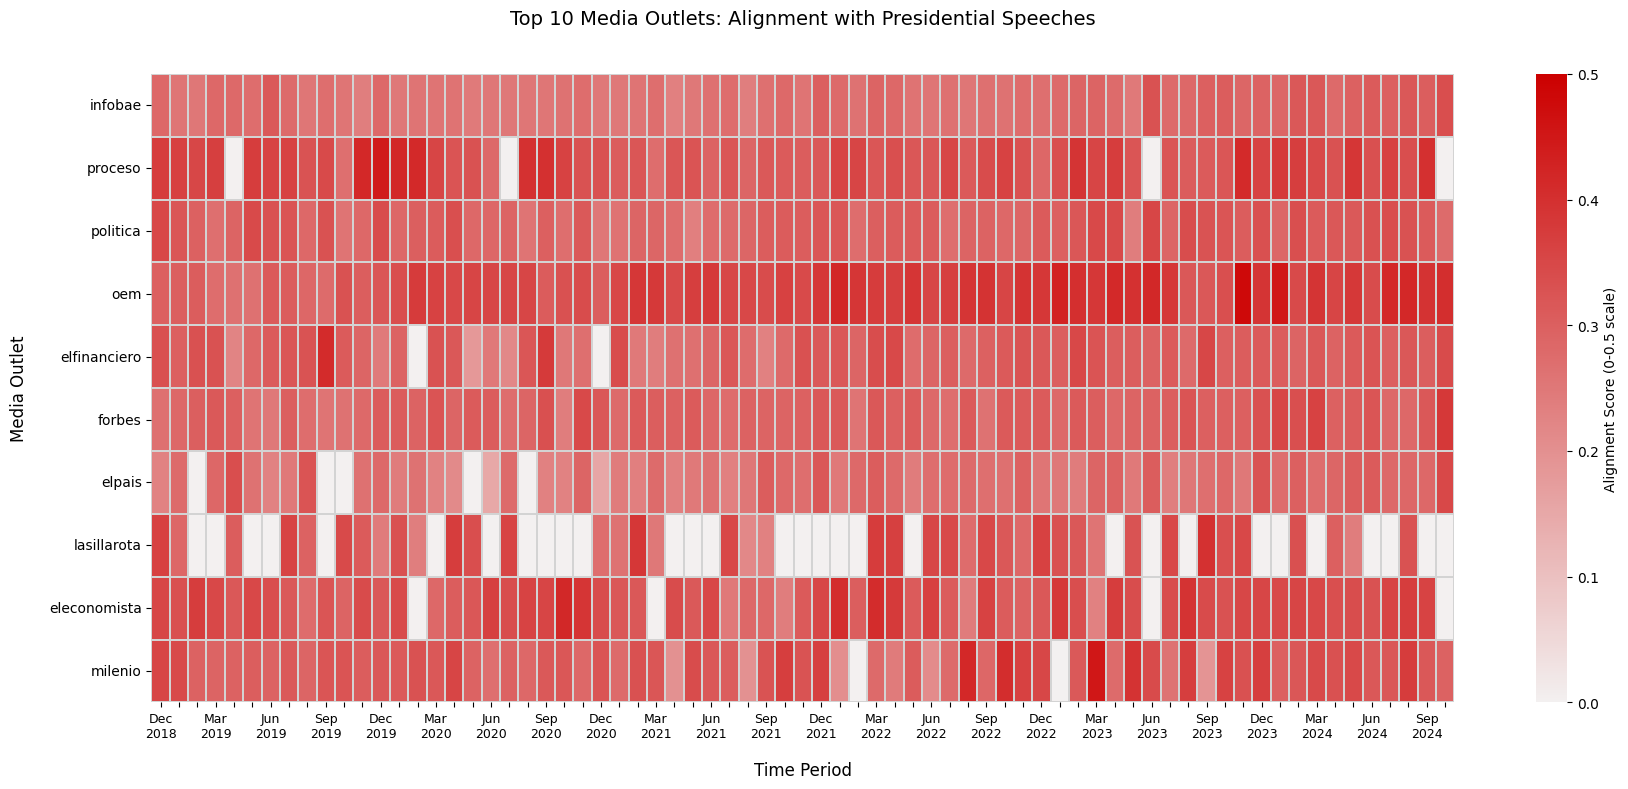

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from matplotlib.colors import Normalize

#Function to extract top media outlets 
def extract_outlet(url):
    """Extract media outlet name from news article URL"""
    patterns = [
        r"https?://(?:www\.)?([^/.]+)\.",
        r"https?://([^/]+)/",
        r"([a-z0-9-]+)\.(com|org|net|edu|gov)"
    ]
    for pattern in patterns:
        match = re.search(pattern, url, re.IGNORECASE)
        if match:
            return match.group(1).lower()
    return "unknown"


def plot_temporal_alignment_heatmap(df, news_metadata, resample_freq='M'):
    """Show alignment patterns for top 10 outlets"""
    # Merge data and clean
    merged_df = df.merge(
        news_metadata[['news_id', 'outlet']],
        on='news_id',
        how='inner'
    ).dropna(subset=['cosine_similarity'])
    
    # Get top 10 outlets by article count
    top_outlets = merged_df.groupby('outlet')['news_id'].nunique() \
                          .nlargest(10).index.tolist()
    
    # Filter to top outlets only
    filtered_df = merged_df[merged_df['outlet'].isin(top_outlets)]
    
    # Prepare temporal data
    filtered_df['period'] = filtered_df['news_date'].dt.to_period(resample_freq)
    pivot_data = filtered_df.groupby(['outlet', 'period'])['cosine_similarity'] \
                          .mean().unstack().fillna(0)
    
    # Sort outlets by total articles (descending)
    outlet_order = filtered_df.groupby('outlet')['news_id'].nunique() \
                             .sort_values(ascending=False).index
    pivot_data = pivot_data.loc[outlet_order]
    
    # Fixed sizing for 10 outlets
    plt.figure(figsize=(18, 8))  # Width 18", Height 8"
    
    # Plot heatmap
    ax = sns.heatmap(
        pivot_data,
        cmap=sns.light_palette("#cc0000", as_cmap=True), #color palette and heatmap 
        norm=Normalize(vmin=0, vmax=0.5),
        linewidths=0.3,
        linecolor='lightgray',
        cbar_kws={'label': 'Alignment Score (0-0.5 scale)'}
    )
    
    # Formatting
    ax.set_title('Top 10 Media Outlets: Alignment with Presidential Speeches\n', pad=20, fontsize=14)
    ax.set_xlabel('Time Period', labelpad=15, fontsize=12)
    ax.set_ylabel('Media Outlet', labelpad=15, fontsize=12)
    ax.set_xticklabels(
        [col.strftime('%b\n%Y') if i%3==0 else '' for i, col in enumerate(pivot_data.columns)],
        rotation=0,
        fontsize=9
    )
    plt.tight_layout()
    plt.show()

#Code to execute instructions, not testing. 

if __name__ == "__main__":
    try:
        # Load data
        news_df = news_embeddings
        similarities_df = pd.read_parquet('news_speech_similarities.parquet')
        
        # Add outlet information
        news_df['outlet'] = news_df['Link'].apply(extract_outlet)
        news_metadata = news_df[['outlet']].reset_index().rename(columns={'index': 'news_id'})
        
        # Generate visualization
        plot_temporal_alignment_heatmap(
            similarities_df,
            news_metadata,
            resample_freq='M'  # Monthly aggregation
        )
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Troubleshooting steps:")
        print(f"1. Verify files exist in: {DATA_DIR}")
        print(f"2. Check file contents: {os.listdir(DATA_DIR)}")
        print("3. Confirm required columns exist in dataframes")

## Statistical Analysis 

Arianna emphasized the unit or level. Meaning is this article level or not? And then, if it is then it makes sense to have it as an article level with time-dependencies. 

In [7]:

# 1. Daily Aggregated Data
#I have to establish within the text the level (article level and speech level)
import pandas as pd
import statsmodels.api as sm


df_daily = daily_agg[['date', 'cosine_similarity']].copy()
df_daily['time'] = (df_daily['date'] - df_daily['date'].min()).dt.days

# Drop missing values
df_daily = df_daily.dropna(subset=['cosine_similarity'])


# Basic OLS: Similarity ~ Time
X = sm.add_constant(df_daily['time'])
y = df_daily['cosine_similarity']

model_time = sm.OLS(y, X).fit()
print("=== Basic Time Regression ===")
print(model_time.summary())


=== Basic Time Regression ===
                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     103.5
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           9.11e-24
Time:                        12:59:03   Log-Likelihood:                 3876.5
No. Observations:                2078   AIC:                            -7749.
Df Residuals:                    2076   BIC:                            -7738.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2811 

In [8]:
import re
# again extracting top media outlets. Maybe there is a more efficient way to do this. 
def extract_outlet(url):
    patterns = [r"https?://(?:www\.)?([^/.]+)\."]
    match = re.search(patterns[0], str(url), re.IGNORECASE)
    return match.group(1).lower() if match else "unknown"

# Create outlet column in news_embeddings
news_embeddings['outlet'] = news_embeddings['Link'].apply(extract_outlet)

# Verify
print("News columns:", news_embeddings.columns.tolist())
print("Sample outlets:", news_embeddings['outlet'].unique()[:5])

News columns: ['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr', 'processed_content', 'news_chunks', 'news_embeddings', 'outlet', 'news_date']
Sample outlets: ['bbc' 'politica' 'oem' 'eleconomista' 'milenio']


In [ ]:
print(enriched_df)

In [9]:
# Now this will work

enriched_df = enriched_df.merge(
    news_embeddings[['outlet']],
    left_on='news_id',
    right_index=True,
    how='left'
)

# Final check
print("\nColumns in enriched_df:", enriched_df.columns.tolist())
print("Sample outlets:", enriched_df['outlet'].unique()[:5])


Columns in enriched_df: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff', 'outlet']
Sample outlets: ['bbc' 'politica' 'oem' 'eleconomista' 'milenio']


In [ ]:
print(enriched_df['days_diff'].nunique())

In [10]:
import statsmodels.api as sm

# Simple regression: cosine similarity ~ Days between speech and news
X_time = sm.add_constant(enriched_df[['days_diff']])
y = enriched_df['cosine_similarity']

model_time = sm.OLS(y, X_time).fit(cov_type='HC3')
print("=== Time Trend Model ===")
print(model_time.summary())

=== Time Trend Model ===
                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:59:23   Log-Likelihood:             2.6827e+07
No. Observations:            24418171   AIC:                        -5.365e+07
Df Residuals:                24418169   BIC:                        -5.365e+07
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3045   1.6

In [13]:
import pandas as pd
import statsmodels.api as sm

# 1. Get top outlets. So again this is repeated 
top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()#im duplocating data here 
# 2. Create dummy variables with proper naming 
dummies = pd.get_dummies(enriched_df['outlet'], prefix='outlet')

In [14]:
# 3. Filter columns using PREFIXED names
dummy_columns = [f'outlet_{outlet}' for outlet in top_outlets if f'outlet_{outlet}' in dummies.columns]
dummies = dummies[dummy_columns]

# 4. Ensure numerical data types
dummies = dummies.astype(int)  # Convert boolean dummies to integers
enriched_df['days_diff'] = pd.to_numeric(enriched_df['days_diff'], errors='coerce')

# 5. Handle missing values
valid_data = enriched_df[['days_diff', 'cosine_similarity']].join(dummies).dropna()

In [15]:
# 6. Create regression matrix
X = sm.add_constant(valid_data[['days_diff'] + dummy_columns])
y = valid_data['cosine_similarity']

# 7. Run regression
model = sm.OLS(y, X).fit(cov_type='HC3')
print("\n=== Outlet Fixed Effects Model ===")
print(model.summary())


=== Outlet Fixed Effects Model ===
                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                 2.139e+05
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:00:30   Log-Likelihood:             2.7793e+07
No. Observations:            24418171   AIC:                        -5.559e+07
Df Residuals:                24418159   BIC:                        -5.559e+07
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------